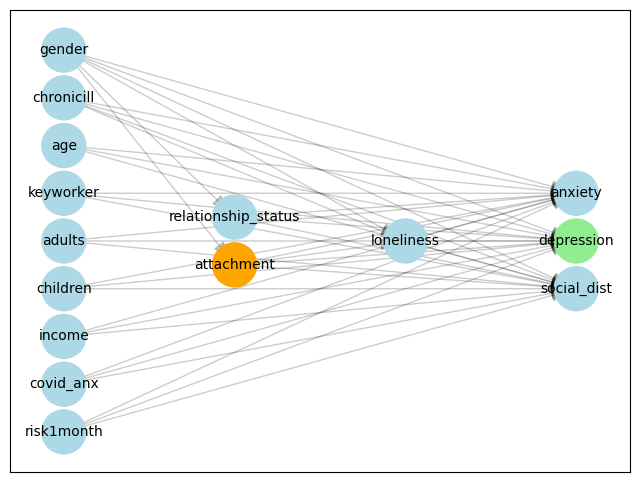

In [21]:
import os
import networkx as nx
import numpy as np
import torch
from CaT.model import CaT
import pandas as pd
import matplotlib.pyplot as plt
from CaT.datasets import reorder_dag, get_full_ordering
from utils.inference import CausalInference
from utils.utils import pad_vectors_with_mask
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR


data_dir = 'data'
data_fn = 'real_world_dataset.csv'
data_path = os.path.join(data_dir, data_fn)

data = pd.read_csv(data_path)
    
w2_age = ['W2_Age_year']
w2_keyworker = ['W2_Keyworker']
w2_adults = ['W2_Adults_household']
w2_children = ['W2_Children_household'] 
w2_income = ['W2_Change_Income'] 
w2_covid_anx = ['W2_COVID19_anxiety']
w2_risk1month = ['W2_RISK_1month'] 

w2_gender = ['W2_Gender']

# attach style {1,2,3,4}
# 1 secure
# 2 avoidant/fearful avoidant
# 3 anxious
# 4 dismissive
w2_attachment = ['W2_Attach_Style']

w2_loneliness = ['W2_Loneliness1',
                'W2_Loneliness2',
                'W2_Loneliness3']
w2_chronicill = ['W2_Chronic_illness_self']
w2_rel_stat = ['W2_Relationship']
w2_social_dist = ['W2_SocialDistance1',
                'W2_SocialDistance2',
                'W2_SocialDistance3',
                'W2_SocialDistance4',
                'W2_SocialDistance5',
                'W2_SocialDistance6',
                'W2_SocialDistance7',
                'W2_SocialDistance8',
                'W2_SocialDistance9',
                'W2_SocialDistance10',
                'W2_SocialDistance11',
                'W2_SocialDistance12',
                'W2_SocialDistance13',
                'W2_SocialDistance14',
                'W2_SocialDistance15',
                'W2_SocialDistance16']

w2_depression = ['W2_Dep_1',
            'W2_Dep_2',
            'W2_Dep_3',
            'W2_Dep_4',
            'W2_Dep_5',
            'W2_Dep_6',
            'W2_Dep_7',
            'W2_Dep_8',
            'W2_Dep_9']
w2_anx = ['W2_GAD_1',
        'W2_GAD_2',
        'W2_GAD_3',
        'W2_GAD_4',
        'W2_GAD_5',
        'W2_GAD_6',
        'W2_GAD_7']

# wave 3 variables
w3_age = ['W3_Age_year']  
w3_gender = ['W3_Age_year']
w3_attachment = ['W3_Attach_style']
# wave 1 variables
w1_age = ['W1_Age_year']  
w1_gender = ['W1_Age_year']
w1_attachment = ['W3_Attach_style']  # no W1 value exists, so just try W3 again

all_vars = [w2_anx, w2_depression, w2_social_dist, w2_age, w2_keyworker, w2_adults, w2_children, w2_income, w2_covid_anx, w2_risk1month,
            w2_gender, w2_attachment, w2_loneliness, w2_chronicill, w2_rel_stat]


# Construct mapping for each variable group
var_mapping = {
    'age': w2_age,
    'keyworker': w2_keyworker,
    'adults': w2_adults,
    'children': w2_children,
    'income': w2_income,
    'covid_anx': w2_covid_anx,
    'risk1month': w2_risk1month,
    'gender': w2_gender,
    'attachment': w2_attachment,
    'loneliness': w2_loneliness,
    'chronicill': w2_chronicill,
    'relationship_status': w2_rel_stat,
    'social_dist': w2_social_dist,
    'depression': w2_depression,
    'anxiety': w2_anx
}

var_types = {key: 'cont' for key in var_mapping.keys()}
# Create the directed acyclic graph (DAG)
DAGnx = nx.DiGraph()

# Add links based on the relationships you provided
DAGnx.add_edges_from([
    ('gender', 'relationship_status'),
    ('gender', 'attachment'),
    ('gender', 'anxiety'),
    ('gender', 'depression'),
    ('gender', 'social_dist'),
    ('gender', 'loneliness'),
    ('attachment', 'loneliness'),
    ('attachment', 'anxiety'),
    ('attachment', 'depression'),
    ('attachment', 'social_dist'),
    ('relationship_status', 'anxiety'),
    ('relationship_status', 'depression'),
    ('relationship_status', 'social_dist'),
    ('loneliness', 'anxiety'),
    ('loneliness', 'depression'),
    ('loneliness', 'social_dist'),
    ('chronicill', 'anxiety'),
    ('chronicill', 'depression'),
    ('chronicill', 'social_dist'),
    ('chronicill', 'loneliness'),
    ('age', 'anxiety'),
    ('age', 'depression'),
    ('age', 'social_dist'),
    ('keyworker', 'anxiety'),
    ('keyworker', 'depression'),
    ('keyworker', 'social_dist'),
    ('adults', 'anxiety'),
    ('adults', 'depression'),
    ('adults', 'social_dist'),
    ('children', 'anxiety'),
    ('children', 'depression'),
    ('children', 'social_dist'),
    ('income', 'anxiety'),
    ('income', 'depression'),
    ('income', 'social_dist'),
    ('covid_anx', 'anxiety'),
    ('covid_anx', 'depression'),
    ('covid_anx', 'social_dist'),
    ('risk1month', 'anxiety'),
    ('risk1month', 'depression'),
    ('risk1month', 'social_dist')
])

for layer, nodes in enumerate(nx.topological_generations(DAGnx)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        DAGnx.nodes[node]["layer"] = layer
        
pos = nx.multipartite_layout(DAGnx, subset_key="layer")  # You can try different layouts like shell_layout, circular_layout, etc.
plt.figure(figsize=(8, 6))

highlight_nodes = ['depression', 'attachment']

# Define node colors: 
# 'depression' and 'anxiety' in lightgreen, 'attachment' in orange, and the rest in lightblue
node_colors = [
    'orange' if node == 'attachment' else 
    'lightgreen' if node in ['depression'] else 
    'lightblue' 
    for node in DAGnx.nodes()
]


# Define node sizes: make highlighted nodes bigger
node_sizes = [1000 if node in highlight_nodes else 1000 for node in DAGnx.nodes()]
# Draw the nodes and edges
nx.draw_networkx_nodes(DAGnx, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_labels(DAGnx, pos, font_size=10)
nx.draw_networkx_edges(DAGnx, pos, arrowstyle='-|>', arrowsize=20, alpha=0.2)

plt.savefig('realworld_dag.png', dpi=150)
plt.show()

In [2]:
DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
var_names = list(DAGnx.nodes())
causal_ordering = get_full_ordering(DAGnx)
ordered_var_types = dict(sorted(var_types.items(), key=lambda item: causal_ordering[item[0]]))

In [3]:
# Assuming df is your pandas DataFrame
def extract_variable_data(df, var_names, var_mapping):
    arraylist = []
    
    for var in var_names:
        # Extract the column names from the var_mapping dictionary
        columns = var_mapping.get(var)
        if columns:
            # Select the relevant columns from the DataFrame
            subset = df[columns]
            # Convert the subset to a NumPy array and append to the list
            arraylist.append(subset.to_numpy())
    
    return arraylist
    
data = pd.read_csv(os.path.join(data_dir, 'real_world_dataset.csv'))
arraylist = extract_variable_data(data, var_names, var_mapping)

In [4]:
np.savez_compressed(os.path.join(data_dir, 'real_world_data.npz'), *arraylist)

# To load the arrays back
loaded_data = np.load(os.path.join(data_dir, 'real_world_data.npz'))
arraylist_loaded = [loaded_data[key] for key in loaded_data.files]

In [5]:
all_data, mask = pad_vectors_with_mask(arraylist_loaded)
all_data.shape

(895, 15, 16)

In [17]:
shuffling = 0
seed = 1
standardize = 0
batch_size = 300
max_iters = 20000
eval_interval = 1000
eval_iters = 100
validation_fraction = 0.0
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 2e-4
ff_n_embed = 30
num_heads = 2
n_layers = 2
head_size = 30
embed_dim = 30
d = data.shape[-1]

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

In [18]:
num_sims = 100 
subsample_fraction = 0.9  # For example, use 80% of the data in each bootstrap iteration

# Lists to store the bootstrap estimates
dep_sec_fear = []
dep_sec_anx = []
dep_sec_avoid  = []

anx_sec_fear = []
anx_sec_anx = []
anx_sec_avoid  = []

for i in range(num_sims):
    print('BOOTSTRAP ITERATION:', i+1, ' of', num_sims)
    # Bootstrap: resample with replacement from a subsample of the original data
    num_subsample = int(subsample_fraction * len(all_data))  # Subsampling size
    indices = np.random.choice(np.arange(len(all_data)), size=num_subsample, replace=True)  # Subsampling with replacement
    
    train_inds = indices[int(validation_fraction * len(indices)):]
    
    train_data = all_data[train_inds]
    train_data = torch.from_numpy(train_data).float()
    
    input_dim = all_data.shape[2]
    
    model = CaT(input_dim=input_dim,
                dropout_rate=dropout_rate,
                head_size=head_size,
                num_heads=num_heads,
                ff_n_embed=ff_n_embed,
                embed_dim= embed_dim,
                dag=DAGnx,
                use_batch_norm=False,
                causal_ordering=causal_ordering,
                n_layers=n_layers,
                device=device,
                var_types=var_types, activation_function='Swish'
                ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    def lr_lambda(epoch):
        if epoch < warmup_iters:
            return float(epoch) / float(max(1, warmup_iters))
        return 1.0
    
    warmup_iters = max_iters // 5  # Number of iterations for warmup
    scheduler_warmup = LambdaLR(optimizer, lr_lambda=lr_lambda)
    scheduler_cyclic = CosineAnnealingLR(optimizer, T_max=max_iters - warmup_iters)
    
    
    # Model training
    for iter_ in range(0, max_iters):
        model.train()
    
        xb = get_batch(train_data=train_data, val_data=None, split='train', device=device, batch_size=batch_size)
        xb_mod = torch.clone(xb.detach())
        X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=shuffling)
        # print('during training orig', model.blocks[0].mha.heads[0].dag_orig)
        # print('during training mod', model.blocks[0].mha.heads[0].dag_mod)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if iter_ < warmup_iters:
            scheduler_warmup.step()
        else:
            scheduler_cyclic.step()
            
        if iter_ % 1000 == 0 or iter_ == max_iters - 1:
            print(f"Iteration {iter_ + 1}/{max_iters}, Loss: {loss.item():.4f}")
    
    # Causal inference after training
    ci = CausalInference(model=model, device=device, mask=mask)
    depression_index = var_names.index('depression')
    anx_index = var_names.index('anxiety')    
    # Bootstrapping intervention comparisons for the 6 estimands
    D0 = ci.forward(data=all_data, intervention_nodes_vals={'attachment': 0.0})  # Baseline: secure attachment
    # print(model.blocks[0].mha.heads[0].dag_orig)
    # print(model.blocks[0].mha.heads[0].dag_mod)
    # 
    for att_val, dep_list, anx_list in zip([1.0, 2.0, 3.0], [dep_sec_fear, dep_sec_anx, dep_sec_avoid], [anx_sec_fear, anx_sec_anx, anx_sec_avoid]):
        D1 = ci.forward(data=all_data, intervention_nodes_vals={'attachment': att_val})
    
        est_ATE_dep = (D1[:,depression_index] - D0[:,depression_index]).mean(0)
        est_ATE_dep = est_ATE_dep.mean()
        dep_list.append(est_ATE_dep)
    
        est_ATE_anx = (D1[:,anx_index] - D0[:,anx_index]).mean(0)
        est_ATE_anx = est_ATE_anx.mean()
        anx_list.append(est_ATE_anx)
        
        print('Att val:', att_val, 'dep_val:', est_ATE_dep)
        print('Att val:', att_val, 'anx_val:', est_ATE_anx)

# After collecting the bootstrap estimates, compute both the means and standard errors

# Depression: secure to fearful avoidant
dep_sec_fear_mean = np.mean(dep_sec_fear)
dep_sec_fear_se = np.std(dep_sec_fear, ddof=1)

# Depression: secure to anxious
dep_sec_anx_mean = np.mean(dep_sec_anx)
dep_sec_anx_se = np.std(dep_sec_anx, ddof=1)

# Depression: secure to avoidant/dismissive
dep_sec_avoid_mean = np.mean(dep_sec_avoid)
dep_sec_avoid_se = np.std(dep_sec_avoid, ddof=1)

# Anxiety: secure to fearful avoidant
anx_sec_fear_mean = np.mean(anx_sec_fear)
anx_sec_fear_se = np.std(anx_sec_fear, ddof=1)

# Anxiety: secure to anxious
anx_sec_anx_mean = np.mean(anx_sec_anx)
anx_sec_anx_se = np.std(anx_sec_anx, ddof=1)

# Anxiety: secure to avoidant/dismissive
anx_sec_avoid_mean = np.mean(anx_sec_avoid)
anx_sec_avoid_se = np.std(anx_sec_avoid, ddof=1)

# Print the means and standard errors
print(f"Mean Depression (secure to fearful): {dep_sec_fear_mean}, SE: {dep_sec_fear_se}")
print(f"Mean Depression (secure to anxious): {dep_sec_anx_mean}, SE: {dep_sec_anx_se}")
print(f"Mean Depression (secure to avoidant): {dep_sec_avoid_mean}, SE: {dep_sec_avoid_se}")
print(f"Mean Anxiety (secure to fearful): {anx_sec_fear_mean}, SE: {anx_sec_fear_se}")
print(f"Mean Anxiety (secure to anxious): {anx_sec_anx_mean}, SE: {anx_sec_anx_se}")
print(f"Mean Anxiety (secure to avoidant): {anx_sec_avoid_mean}, SE: {anx_sec_avoid_se}")


BOOTSTRAP ITERATION: 1  of 100
Iteration 1/20000, Loss: 3276.9517
Iteration 1001/20000, Loss: 103.4395
Iteration 2001/20000, Loss: 13.7936
Iteration 3001/20000, Loss: 5.8247
Iteration 4001/20000, Loss: 3.4478
Iteration 5001/20000, Loss: 3.1612
Iteration 6001/20000, Loss: 2.3474
Iteration 7001/20000, Loss: 2.1345
Iteration 8001/20000, Loss: 2.1811
Iteration 9001/20000, Loss: 2.1120
Iteration 10001/20000, Loss: 2.0575
Iteration 11001/20000, Loss: 1.8587
Iteration 12001/20000, Loss: 1.9905
Iteration 13001/20000, Loss: 1.9417
Iteration 14001/20000, Loss: 1.9069
Iteration 15001/20000, Loss: 1.8089
Iteration 16001/20000, Loss: 1.8440
Iteration 17001/20000, Loss: 1.8867
Iteration 18001/20000, Loss: 1.7957
Iteration 19001/20000, Loss: 1.7704
Iteration 20000/20000, Loss: 1.7528
Att val: 1.0 dep_val: 0.021369942
Att val: 1.0 anx_val: 0.023521848
Att val: 2.0 dep_val: 0.03404375
Att val: 2.0 anx_val: 0.03935226
Att val: 3.0 dep_val: 0.038909696
Att val: 3.0 anx_val: 0.048579648
BOOTSTRAP ITERATIO